# Thesis Project

## Requirements and Imports

All requirements in this project are managed by `Pipenv` and are denoted in the `Pipfile`, which can be found in the same directory.

In [1]:
# Basic imports
import os
import re
import math
import glob
import wfdb
import time
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# PyTorch related imports
import torch
import torchinfo
import torch.nn as nn
import torch.jit as jit
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# RayTune related imports
from ray import tune, put, get
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Sklearn and Scipy related imports
from scipy import signal
from statsmodels.tsa.stattools import ccf
from skimage.restoration import denoise_wavelet
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Configuration

This the following code cell can be used to configure certain aspects of the experiment.
To specify offsets (for instance for the sampling rate or the segment size), please refer to the official [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [2]:
# Set a random seed for pytorch (always split the data the same way), for the random package and for numpy. Required for reproducability.
random.seed(1658497162847124986)
torch.manual_seed(1658497162847124986)
np.random.seed(1658497162)

# If a GPU (Cuda) is available, it will be used to train and test the machine learning models.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The directory for saving and loading the trained models.
model_directory = './models/'

# Here, some basic settings for the datasets and are set.
data_directory = './data/'
sampling_rate = '10L' # 10ms, The signal will be resampled based on this sampling rate.
segment_size = '10240L' # 10240 ms, The signal will be split based on this length.
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())
train_split = 0.8

# The target noise SNR values for training and testing.
train_target_snr_dbs = [-1.5, 0, 1.5, 3.5, 5, 6.5] # dB
test_target_snr_dbs =  [-1, 0, 0.5, 1, 3, 5, 8] # dB

# Number of epochs for training.
num_epochs = 256

## Dataset

This is a utilitarian class which is used for managing the required data. It inherits from the PyTorch `Dataset` class, which provides tools like splitting the data into train and test subsets or using it in dataloaders to efficiently access the data. The dataset for this experiment coprises the CEBS dataset and another dataset, called D2. The data from the denoted datasets will be loaded directly when initialising an object of the class. Each dataset will be imported, depending on its specific characteristics, the schemas will be normalized, the two dataset will be resampled and each dataset will be grouped according to `segment_size_samples`. Subsequelty, the two datasets will be combined. Initially, no noise will be added to the data, i.e. the clean and noisy data will be the same in the beginning. This is done so that training and testing can be done with different noise levels. The noise generated is gaussian white noise. However, this can be substituted with some other noise generation mechanism later, when required. Please note that the code for generating the noise was adopted from [this](https://stackoverflow.com/a/53688043) example.

In [3]:
def normalize(clean, noise):
    x_concat = np.concatenate((clean, noise))
    min_val = np.min(x_concat)
    max_val = np.max(x_concat)
    y_clean = 2 * (clean-min_val) / (max_val - min_val) - 1
    y_noise = 2 * (noise-min_val) / (max_val - min_val) - 1
    return y_clean, y_noise, min_val, max_val

def denormalize(clean, noise, min_val, max_val):
    y_clean = (max_val * clean + max_val - clean * min_val + min_val) / 2
    y_noise = (max_val * noise + max_val - noise * min_val + min_val) / 2
    return y_clean, y_noise

def bandpass(input_signal):
    # https://www.youtube.com/watch?v=juYqcck_GfU
    fs = 100.0 # frequency space
    lowcut = 5.0 # Hz
    highcut = 30.0 # Hz

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 4

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

In [9]:
class SCGData(Dataset):

    def __init__(self, directory=None, datasets=None, transform=None, ecg=False):

        self.directory = directory
        self.datasets = datasets
        self.transform = transform
        self.ecg = ecg

        data = self.__load_datasets()

        # data = data.apply(lambda x: bandpass(x))
        # data = pd.DataFrame({'clean': data, 'noise': data})
        
        if self.ecg:
            self.x_data = data.SCG.values
            self.y_data = data.ECG.values
        else:
            self.x_data = data.SCG.values
            self.y_data = data.SCG.values

        self.n_samples = data.shape[0]


    def add_noise(self, target_snr_dbs):

        if not self.ecg:
            self.x_data = np.array([self.__add_gaussian(inputs, target_snr_dbs) for inputs in self.y_data])


    def __add_gaussian(self, data, target_snr_dbs):

        # target_snr_db = random.choices(target_snr_dbs, weights=target_snr_weights, k=1)[0]
        target_snr_db = random.choice(target_snr_dbs)
        # target_snr_db = random.uniform(-1, 20) # sample from bigger range provides better results?
        # target_snr_db = 1

        data_watts = data ** 2
        data_avg_watts = np.mean(data_watts)
        data_avg_db = 10 * np.log10(data_avg_watts)

        noise_avg_db = data_avg_db - target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)

        mean_noise = 0
        noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

        data_noisy = data + noise
        return data_noisy


    # Function to import the CEBS dataset
    def __load_cebs(self, filename):
        
        # Using WFDB to import the files.
        record = wfdb.rdsamp(filename)
        data = record[0]
        metadata = record[1]

        frequency = metadata['fs']
        column_names = metadata['sig_name']
        length = metadata['sig_len']

        data = pd.DataFrame(data, columns=column_names)
        data.drop(['II', 'RESP'], axis=1, inplace=True)
        data.rename(columns={'I': 'ECG'}, inplace=True)

        # Create a datetime index, as it is not given in the dataset. Required for resampling and splitting the data.
        frequency_string = str(int(1/frequency*1000000)) + 'U'
        index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
        data.set_index(index, inplace=True)

        # Resample the data into the desired sampling rate.
        data = data.resample(sampling_rate).mean()

        # Split the data into groups with segment_size_samples samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=1024, step=128) if x.shape[0] == 1024 and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']

        # data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        # data = data[data.apply(lambda x: len(x) == segment_size_samples)]
        # data = data.apply(lambda x: np.array(x))
        
        return data


    # Function to import the D2 dataset
    def __load_d2(self, filename):

        # Since the files are not structured the same, they have to be imported differently. The following code does that.
        # Regex to identify files with specific names, as they are structured differently.
        regex_up_1 = re.compile(r'./data/D2/UP-(((0|1)[0-9])|(20|21))-*') # Files named UP-[01-21]-Raw.csv
        regex_up_2 = re.compile(r'./data/D2/UP-(22|23)-*') # Files named UP-[22-23]-Raw.csv

        # Import and normalize the structures of the different files.
        if re.match(r'./data/D2/CP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['Shimmer_D0CD_Timestamp_Shimmer_CAL', 'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL', 'Shimmer_D0CD_Accel_LN_Z_CAL'], 
                    dtype={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'float', 'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'index', 'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'ECG', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif regex_up_1.match(filename):
            data = pd.read_csv(filename, 
                    sep='	', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_TimestampSync_Unix_CAL', 'ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_TimestampSync_Unix_CAL': 'float', 'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_TimestampSync_Unix_CAL': 'index', 'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif regex_up_2.match(filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_Timestamp_Unix_CAL', 'ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_Timestamp_Unix_CAL': 'float', 'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_Timestamp_Unix_CAL': 'index', 'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif re.match(r'./data/D2/UP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=0, 
                    skiprows=[1],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)

            # The datetime index is not set correctly. Therefore, it has to be set set manually. The frequency was obtained from the original paper. Please refer to the thesis for further information.
            frequency = 512
            frequency_string = str(int(1/frequency*1000000000)) + 'N'
            data['index'] = pd.date_range(start='1/1/1970', periods=data.shape[0], freq=frequency_string)
        else:
            return pd.DataFrame()

        data['index'] = pd.to_datetime(data['index'], unit='ms')
        data.set_index('index', inplace=True)

        # Resample the data into the desired sampling rate.
        data = data.resample(sampling_rate).mean()

        # Split the data into groups with segment_size_samples samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=1024, step=128) if x.shape[0] == 1024 and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']

        #data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        #data = data[data.apply(lambda x: len(x) == segment_size_samples and not np.isnan(x).any())]
        #data = data.apply(lambda x: np.array(x))

        return data

    # Loads the datasets denoted in the datasets parameter.
    def __load_datasets(self):

        data = pd.Series(dtype='object')

        # Loads the CEBS dataset from the 'CEBS' directory in the directory folder.
        if 'CEBS' in self.datasets:
            directory = os.path.join(self.directory, 'CEBS')
            filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(f'{directory}/*[0-9][0-9][0-9].*')]))
            data = pd.concat((self.__load_cebs(filename) for filename in filenames), ignore_index=True)

        # Loads the D2 dataset from the 'D2' directory in the directory folder.
        if 'D2' in self.datasets:
            directory = os.path.join(self.directory, 'D2')
            filenames = glob.glob(f'{directory}/*')
            data2 = pd.concat((self.__load_d2(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data2))

        return data

    # Returns a sample with the specified index and applies the transformation, if it is set.
    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    
    def __len__(self):
        return self.n_samples


# Transformation class used to transform the numpy arrays to PyTorch tensors.
class ToTensor:

    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [5]:
# Loads the data and returns splitted test and train datasets
def load_data(directory, datasets, transform, ecg=False):
    dataset = SCGData(directory=directory, datasets=datasets, transform=transform, ecg=ecg)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
# Imports the dataset and splits it into a train and test subset. 
train_dataset, test_dataset = load_data(directory=data_directory, datasets=['D2'], transform=ToTensor(), ecg=True)

## Machine Learning Models

In [ ]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 7, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/2), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 7, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), layer_size, 7, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.ConvTranspose1d(layer_size, 1, 7, stride=1), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the Autoencoder
torchinfo.summary(DeNoise1(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 1000]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1018]
│    └─BatchNorm1d: 2-2                  [32, 128, 1018]           [32, 128, 1018]
│    └─ELU: 2-3                          [32, 128, 1018]           [32, 128, 1018]
│    └─Conv1d: 2-4                       [32, 128, 1018]           [32, 64, 1012]
│    └─BatchNorm1d: 2-5                  [32, 64, 1012]            [32, 64, 1012]
│    └─ELU: 2-6                          [32, 64, 1012]            [32, 64, 1012]
│    └─Conv1d: 2-7                       [32, 64, 1012]            [32, 32, 1006]
│    └─BatchNorm1d: 2-8                  [32, 32, 1006]            [32, 32, 1006]
│    └─ELU: 2-9                          [32, 32, 1006]            [32, 32, 1006]
│    └─Conv1d: 2-

In [ ]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 7, stride=1, padding=0),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), int(layer_size/8), 7, stride=2, padding=0),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/8), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/8), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/8), int(layer_size/4), 7, stride=2, output_padding=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size), 7, stride=1, output_padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the Autoencoder
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 497]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1018]
│    └─BatchNorm1d: 2-2                  [32, 128, 1018]           [32, 128, 1018]
│    └─ELU: 2-3                          [32, 128, 1018]           [32, 128, 1018]
│    └─Conv1d: 2-4                       [32, 128, 1018]           [32, 32, 1012]
│    └─BatchNorm1d: 2-5                  [32, 32, 1012]            [32, 32, 1012]
│    └─ELU: 2-6                          [32, 32, 1012]            [32, 32, 1012]
│    └─Conv1d: 2-7                       [32, 32, 1012]            [32, 16, 503]
│    └─BatchNorm1d: 2-8                  [32, 16, 503]             [32, 16, 503]
│    └─ELU: 2-9                          [32, 16, 503]             [32, 16, 503]
│    └─Conv1d: 2-10  

In [ ]:
class DeNoise3(nn.Module):
    def __init__(self, kernel_size=16, filters_1=128, filters_2=64):
        super(DeNoise3, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.ReLU()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded

#print(segment_size_samples/2 + 7)
#print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise3(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise3                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 5]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 505]
│    └─BatchNorm1d: 2-2                  [32, 128, 505]            [32, 128, 505]
│    └─ELU: 2-3                          [32, 128, 505]            [32, 128, 505]
│    └─Conv1d: 2-4                       [32, 128, 505]            [32, 64, 246]
│    └─BatchNorm1d: 2-5                  [32, 64, 246]             [32, 64, 246]
│    └─ELU: 2-6                          [32, 64, 246]             [32, 64, 246]
│    └─Conv1d: 2-7                       [32, 64, 246]             [32, 64, 117]
│    └─BatchNorm1d: 2-8                  [32, 64, 117]             [32, 64, 117]
│    └─ELU: 2-9                          [32, 64, 117]             [32, 64, 117]
│    └─Conv1d: 2-10          

## Training

In [ ]:
def train(config, train_dataset, model_num, is_tune=False, data_id=None, checkpoint_dir=None, data_dir=None):

    if model_num in [1]:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num in [2, 3]:
        model = DeNoise2(layer_size=config['layer_size'])
    elif model_num in [4]:
        model = DeNoise3()
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    # if checkpoint_dir != None:
    #    model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
    #    model.load_state_dict(model_state)
    #    optimizer.load_state_dict(optimizer_state)

    if data_id:
        train_dataset = get(data_id)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    for epoch in range(num_epochs):
        
        train_loss = 0.0
        train_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            
            lables, inputs, _, _ = normalize(lables, inputs)

            #if model_num == 3:
            #    inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                
            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.to(device, dtype=torch.float), lables.to(device, dtype=torch.float)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_steps += 1
        
        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        for i, (inputs, lables) in enumerate(val_loader):

            lables, inputs, _, _ = normalize(lables, inputs)

            #if model_num == 3:
            #    inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.to(device, dtype=torch.float), lables.to(device, dtype=torch.float)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)

            output = model(inputs)
            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values}).to_csv(f'./models/loss_{model_num}.csv') 
            
            if min_val_loss > val_loss:
                
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(model_directory, f'model_{model_num}.pth'))

In [ ]:
# Add the correct noise levels for the training process.
train_dataset.dataset.add_noise(train_target_snr_dbs)

{'lr': 0.0018729000345412963, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004914292857526488
{'lr': 0.0018437162360595998, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007439919008643882
{'lr': 0.0006948120282769452, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013009571703150868

{'lr': 0.0017898461100052906, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0015937495978413632
{'lr': 0.004531902539657156, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0005863353168515718 w/o bandpass, 10
{'lr': 0.0017668188704620857, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0009116247971238728 bandpass, 10
{'lr': 0.006820280279552952, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004986349987892337 with 2x stride 2
{'lr': 0.007810417589096403, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004332348386333898 with 1x stride 2
{'lr': 0.0015365439418637585, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007714835297364866
{'lr': 0.02716233959851866, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0013283919510080145
{'lr': 0.0019890548242081614, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.00144807931687008
{'lr': 0.0038625945811403732, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013378030157384826
{'lr': 0.0017112891648358517, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0019708356504062456
{'lr': 0.0029673206198941445, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0008134577474093409
{'lr': 0.00032813453637735567, 'wd': 0, 'batch_size': 64, 'layer_size': 128} 0.0008
{'lr': 0.0011704653180570925, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0010375047129388723
{'lr': 0.0025766834278764987, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0018318614236014928

In [ ]:
# train({'lr': 0.002, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 1)
train({'lr': 0.001, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 2)
# train({'lr': 0.0005, 'wd': 0, 'batch_size': 8, 'layer_size': 128}, train_dataset, 3)
# train({'lr': 0.005, 'wd': 0, 'batch_size': 8, 'layer_size': 128}, train_dataset, 4)

epoch 1 / 256, train loss = 0.0154229311, val loss = 0.0162361232
	val loss decreased from inf to 18.0383328314
epoch 2 / 256, train loss = 0.0147817901, val loss = 0.0160699671
	val loss decreased from 18.0383328314 to 17.8537334235
epoch 3 / 256, train loss = 0.0137796000, val loss = 0.0135082562
	val loss decreased from 17.8537334235 to 15.0076726539
epoch 4 / 256, train loss = 0.0098254837, val loss = 0.0103003050
	val loss decreased from 15.0076726539 to 11.4436388113
epoch 5 / 256, train loss = 0.0066349939, val loss = 0.0076369783
	val loss decreased from 11.4436388113 to 8.4846828657
epoch 6 / 256, train loss = 0.0051810421, val loss = 0.0060012493
	val loss decreased from 8.4846828657 to 6.6673879183
epoch 7 / 256, train loss = 0.0043890019, val loss = 0.0051693778
	val loss decreased from 6.6673879183 to 5.7431787603
epoch 8 / 256, train loss = 0.0037573145, val loss = 0.0061477110
epoch 9 / 256, train loss = 0.0032725798, val loss = 0.0037440914
	val loss decreased from 5.74

KeyboardInterrupt: 

## Hyperparametertuning

The following code cell implements the hyperparametertuning. It was modeled after a [tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) by PyTorch, using RayTune as a tool for hyperparameter tuning. For optimizing the hyperparameters, the `ASHAScheduler` is being used and the loss should be minimized. The configuration defines the hyperparameters to be optimized. Here only the learning rate `lr`, the batch size `batch_size` and the layer size `layer_size` of the models will be taken into consideration.

In [ ]:
def hypertuning(dataset, config, num_samples, max_num_epochs, model_num):

    # train_dataset.dataset.add_noise(train_target_snr_dbs)
    scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
    reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
    data_id = put(dataset)
    result = tune.run(
        partial(train, train_dataset=None, model_num=model_num, is_tune=True, data_id=data_id, checkpoint_dir=None, data_dir=None),
        resources_per_trial={'cpu': 8, 'gpu': 1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial('loss', 'min', 'last')
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

    best_trained_model =  DeNoise2().to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
    best_trained_model.load_state_dict(model_state)

In [ ]:
config = {
    'lr': tune.loguniform(1e-4, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8, 64, 128]),
    'layer_size': tune.choice([128, 256])
}

# hypertuning(train_dataset, config, num_samples=64, max_num_epochs=32, model_num=2)

## Testing and Evaluation

The following code cells are used for testing and evaluation.

In [ ]:
# Here, some evaluation metrics are implemented.

# Mean-Squared Error
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

# Mean-Absolute Error
def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

# Root Mean-Squared Error
def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

# Signal-to-noise ratio
def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

# Peak signal-to-noise ratio
def psnr(signal_clean, signal_noisy):
    max_clean = np.max(signal_clean)
    rmse_val = rmse(signal_clean, signal_noisy)
    return 20 * np.log10(max_clean / rmse_val)

# Root mean squared difference
def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_clean - signal_noisy) ** 2) / np.sum(signal_clean ** 2)) * 100

# Cross-Correlation
def xcorr(signal_clean, signal_noisy):
    return np.mean(ccf(signal_clean, signal_noisy, adjusted=False))

# Pearson Correlation Coefficient
def pcorr(signal_clean, signal_noisy):
    return np.corrcoef(signal_clean, signal_noisy)[1][0]

In [ ]:
def plot_result_bar(name_short, results, labels, target_snr_print, xlabel, ylabel, title, directory):
    data = [[np.mean(results[method][scope][name_short]) for method in results.keys()] for scope in target_snr_print + ['all']]
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    width = 0.12

    for i in range(len(target_snr_print) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_print + ['all'])
    
    plt.savefig(os.path.join(directory, name_short + '.png'), format='png')
    plt.show()

def save_results(results, config):

    if not os.path.exists('./results'):
        os.mkdir('./results')

    # run_name = str(len(os.listdir('./results')))
    # working_dir = os.path.join('./results', run_name)
    # working_dir = os.mkdir(working_dir)

    working_dir = os.path.join('./results', '2')

    results_print = {method: {scope: {evaluation: {mean: float(np.mean(values)), sd: float(np.std(values))} for evaluation, values in eval_method.items()} for scope, eval_method in method_value.items()} for method, method_value in results.items()}
    with open(os.path.join(working_dir, 'results.json'), 'w+') as output_file:
        json.dump(results_print, output_file, indent=4)

    plot_result_bar('snr_imp', results, config['labels'], config['target_snr_print'], config['xlabel'], 'SNR Improvement (dB)', 'Mean SNR Improvement', working_dir)
    plot_result_bar('mse', results, config['labels'], config['target_snr_print'], config['xlabel'], 'MSE', 'Mean MSE', working_dir)
    plot_result_bar('rmse', results, config['labels'], config['target_snr_print'], config['xlabel'], 'RMSE', 'Mean RMSE', working_dir)
    plot_result_bar('mae', results, config['labels'], config['target_snr_print'], config['xlabel'], 'MAE', 'Mean MAE', working_dir)
    plot_result_bar('psnr', results, config['labels'], config['target_snr_print'], config['xlabel'], 'PSNR', 'Mean PSNR', working_dir)
    plot_result_bar('xcorr', results, config['labels'], config['target_snr_print'], config['xlabel'], 'Cross Correlation', 'Mean Cross Correlation', working_dir)
    plot_result_bar('pcorr', results, config['labels'], config['target_snr_print'], config['xlabel'], 'Pearson Correlation Coefficient', 'Mean Pearson Correlation Coefficient', working_dir)
    plot_result_bar('prd', results, config['labels'], config['target_snr_print'], config['xlabel'], 'PRD (%)', 'Mean PRD', working_dir)

    # CPU Consumption
    data = [np.mean(results[method]['all']['cpu_time']) * 1000 for method in results.keys()]

    plt.xticks(range(len(data)), config['labels'])
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    
    plt.savefig(os.path.join(working_dir, 'cpu.png'))
    plt.show()

In [ ]:
def test(config):
    
    with torch.no_grad():

        ae1 = DeNoise2(layer_size=256).to(device)
        ae1.load_state_dict(torch.load(os.path.join(model_directory, config['models'][0])))
        ae1.eval()

        ae2 = DeNoise1(layer_size=256).to(device)
        ae2.load_state_dict(torch.load(os.path.join(model_directory, config['models'][1])))
        ae2.eval()

        ae3 = DeNoise2(layer_size=256).to(device)
        ae3.load_state_dict(torch.load(os.path.join(model_directory, config['models'][2])))
        ae3.eval()

        ae4 = DeNoise2(layer_size=256).to(device)
        ae4.load_state_dict(torch.load(os.path.join(model_directory, config['models'][3])))
        ae4.eval()

        results = {}

        for method in config['methods']:
            
            results[method] = {}
            for target in test_target_snr_dbs + ['all']:
                results[method][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'psnr': [],
                    'xcorr': [],
                    'pcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            i = 0
            for i, (noise, clean) in enumerate(test_dataset):

                cpu_time = 0
                clean, noise, min_val, max_val = normalize(clean, noise)

                if method == 'AE1':
                    
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device, dtype=torch.float)

                    cpu_time_start = time.process_time()
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE2':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device, dtype=torch.float)

                    cpu_time_start = time.process_time()
                    predicted = ae2(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                elif method == 'AE3':
                    # noise = noise.numpy()

                    # cpu_time_start = time.process_time()
                    # predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    # noise = torch.from_numpy(predicted)
                    # noise = noise.reshape(-1, 1, segment_size_samples).to(device)
                    # predicted = ae1(noise)
                    # cpu_time_stop = time.process_time()
                    # cpu_time = cpu_time_stop - cpu_time_start

                    # noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    # predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()

                    noise = noise.reshape(-1, 1, segment_size_samples).to(device, dtype=torch.float)

                    cpu_time_start = time.process_time()
                    predicted = ae3(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE4':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device, dtype=torch.float)

                    cpu_time_start = time.process_time()
                    predicted = ae4(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                else:
                    break

                clean_old = clean.numpy()
                clean, noise = denormalize(clean_old, noise, min_val, max_val)
                _, predicted = denormalize(clean_old, predicted, min_val, max_val)

                snr_data = snr(clean, noise)
                for target in test_target_snr_dbs + ['all']:
                    if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                        i += 1
                        results[method][target]['result'].append(predicted)
                        results[method][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                        results[method][target]['mse'].append([mse(clean, predicted)])
                        results[method][target]['rmse'].append([rmse(clean, predicted)])
                        results[method][target]['mae'].append([mae(clean, predicted)])
                        # results[method][target]['psnr'].append([psnr(clean, predicted)])
                        if config['mode'] == 1 and method == 'AE1':
                            results[method][target]['xcorr'].append([xcorr(clean, predicted)])
                            results[method][target]['pcorr'].append([pcorr(clean, predicted)])
                        elif config['mode'] == 1 and method in ['AE1', 'AE3']:
                            results[method][target]['xcorr'].append([xcorr(bandpass(clean), bandpass(predicted))])
                            results[method][target]['pcorr'].append([pcorr(bandpass(clean), bandpass(predicted))])
                        else:
                            results[method][target]['xcorr'].append([xcorr(bandpass(clean), bandpass(predicted))])
                            results[method][target]['pcorr'].append([pcorr(bandpass(clean), bandpass(predicted))])
                        results[method][target]['prd'].append([prd(clean, predicted)])
                        results[method][target]['cpu_time'].append(cpu_time)
            
            print(i)
            value = 'all'
            print('*** ' + method + ' ***')
            print(len(results[method][value]['result']))
            print('SNR IMP ' + str(np.mean(results[method][value]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[method][value]['rmse'])))
            print('PRD ' + str(np.mean(results[method][value]['prd'])))
            print('CPU TIME ' + str(np.mean(results[method][value]['cpu_time'])))
            print()

        return results

In [ ]:
# Testing is done with a different set of target signal-to-noise ratios. Those are set here.
train_dataset.dataset.add_noise(test_target_snr_dbs)

In [ ]:
# The config describes, which parameters should be tested.
config0 = {
    'mode': 1,
    'methods': ['AE1', 'AE2', 'AE3', 'AE4'], #, 'WD']# , 'AE1+WD']
    'models': ['new/model_2.pth', 'old/normal_full/model_2_1024_relu_extended_10_3.pth', 'old/normal_full/model_2_1024_relu_extended_10_3.pth', 'old/normal_full/model_2_1024_relu_extended_20.pth'],
    'labels': ['Training Data', 'Results', 'Training Data + Results', 'No Usage'],
    'target_snr_print': [-1, 0, 1, 3, 8], # [-1, 0, 0.5, 1, 3, 5, 8]
    'xlabel': 'Bandpass Filter Usage'
}

config1 = {
    'mode': 0,
    'methods': ['AE1', 'AE2', 'AE3', 'AE4'], #, 'WD']# , 'AE1+WD']
    'models': ['normal_full/model_2_1024_relu_simple.pth', 'normal_full/model_2_1024_relu_extended_5.pth', 'normal_full/model_2_1024_relu_extended_10_3.pth', 'normal_full/model_2_1024_relu_extended_20.pth'],
    'labels': ['1', '2', '3', '4'],
    'target_snr_print': [-1, 0, 1, 3, 8], # [-1, 0, 0.5, 1, 3, 5, 8]
    'xlabel': 'Noise Distribution'
}

config2 = {
    'mode': 0,
    'methods': ['AE1', 'AE2', 'WD'],
    'models': ['model_2.pth', 'old/normal_full/model_1_1024_relu_extended_10.pth', 'old/normal_full/model_2_1024_relu_extended_10.pth', 'old/normal_full/model_2_1024_relu_extended_20.pth'],
    'labels': ['AE1', 'AE2', 'WD'],
    'target_snr_print': [-1, 0, 1, 3, 8], # [-1, 0, 0.5, 1, 3, 5, 8]
    'xlabel': 'Denoising Method'
}

# 10 --> old, 10_3 --> newest
results = test(config2)
save_results(results, config2)

KeyboardInterrupt: 

5594
3.457251
0.008953229

1.2361339
0.065762825

-27.380282878875732
-1.5127694606781006
-13.915828466415405

-14.423694610595703
11.443817615509033

-0.0003298376886509953
-0.0004628211847015212



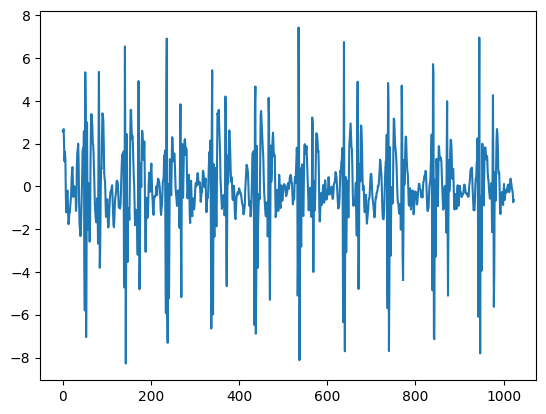

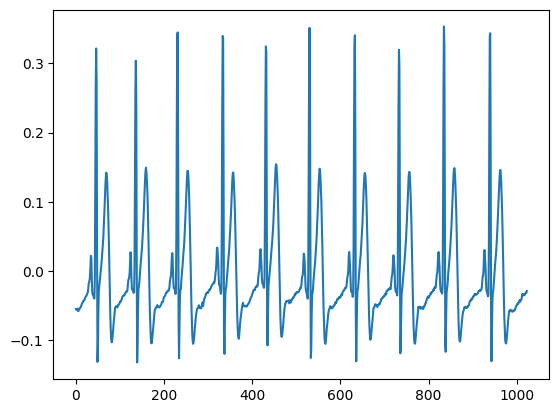

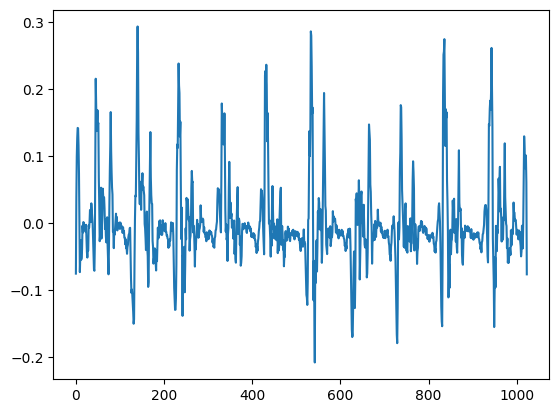

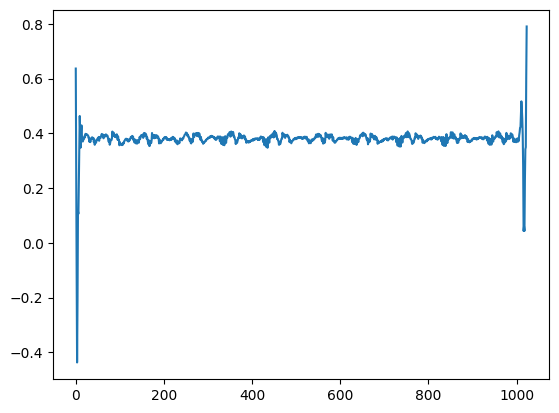

In [ ]:
model1 = DeNoise2(layer_size=256).to(device)
model1.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))

model2 = DeNoise2(layer_size=128).to(device)
# model2.load_state_dict(torch.load(os.path.join(model_directory, 'loss_2_1024_relu_extended_5.pth')))

model1.eval()
model2.eval()

with torch.no_grad():
    
    i = random.choice(range(0, len(test_dataset)))
    print(i)

    noise = test_dataset[i][0]
    clean = test_dataset[i][1]

    clean, noise, min_val, max_val = normalize(clean, noise)
    clean = clean.reshape(-1, 1, segment_size_samples).to(device, dtype=torch.float)
    noise = noise.reshape(-1, 1, segment_size_samples).to(device, dtype=torch.float)

    predicted = model1(noise).to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = model2(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean_old = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    
    clean, noise = denormalize(clean_old, noise, min_val, max_val)
    _, predicted = denormalize(clean_old, predicted, min_val, max_val)
    _, predicted2 = denormalize(clean_old, predicted2, min_val, max_val)
    # predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

    from_val = 0
    to_val = 1024

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time_to = 1024

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], clean[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted2[time_from:time_to])
    plt.show()

    torch.cuda.empty_cache()